In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-prediction/features.csv
/kaggle/input/walmart-sales-prediction/stores.csv
/kaggle/input/walmart-sales-prediction/train.csv
/kaggle/input/walmart-sales-prediction/test.csv


In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pmdarima
from pmdarima import auto_arima
sns.set(rc={'figure.figsize': (25, 8)})
warnings.simplefilter('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00


In [3]:
df_store = pd.read_csv('../input/walmart-sales-prediction/stores.csv')
df_train = pd.read_csv('../input/walmart-sales-prediction/train.csv') # train set
df_features = pd.read_csv('../input/walmart-sales-prediction/features.csv') #external information

In [4]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
# merging 3 different sets on conditions
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [8]:
df.shape

(421570, 17)

In [9]:
df.columns.tolist()
#since is_holiday was duplicated while merging features and train, we'll remove one column

['Store',
 'Dept',
 'Date',
 'Weekly_Sales',
 'IsHoliday_x',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'IsHoliday_y',
 'Type',
 'Size']

In [10]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [11]:
#printing the average weekly sales for each store(1-45) and corresponding departments(1-99)
pd.options.display.max_columns=100 
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [12]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


Negative and NAN values can be observed from the data here.  

In [13]:
#Dropping these rows 
#df = df.loc[df['Weekly_Sales'] > 0]
df.shape

(421570, 16)

In [14]:
#Identifying the Holidays in the dataset
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

**SARIMA**

In [15]:
# Converting Date into Year-Week format
train = pd.read_csv('../input/walmart-sales-prediction/train.csv', parse_dates=['Date'])
train['Date'] =  train.Date.dt.strftime('%Y-%U')
train = train.set_index(['Date'])[['Weekly_Sales']]
print('\n TRAIN')
print(train.shape)
print(train.head())

# Aggregating the weekly sales for every week from all the stores and departments
print('\n TRAIN GROUPED')
walmart_weekly_sales = train.groupby(by=train.index).sum()
print(walmart_weekly_sales.shape)
print(walmart_weekly_sales.head())


 TRAIN
(421570, 1)
         Weekly_Sales
Date                 
2010-05      24924.50
2010-06      46039.49
2010-07      41595.55
2010-08      19403.54
2010-09      21827.90

 TRAIN GROUPED
(143, 1)
         Weekly_Sales
Date                 
2010-05   49750740.50
2010-06   48336677.63
2010-07   48276993.78
2010-08   43968571.13
2010-09   46871470.30


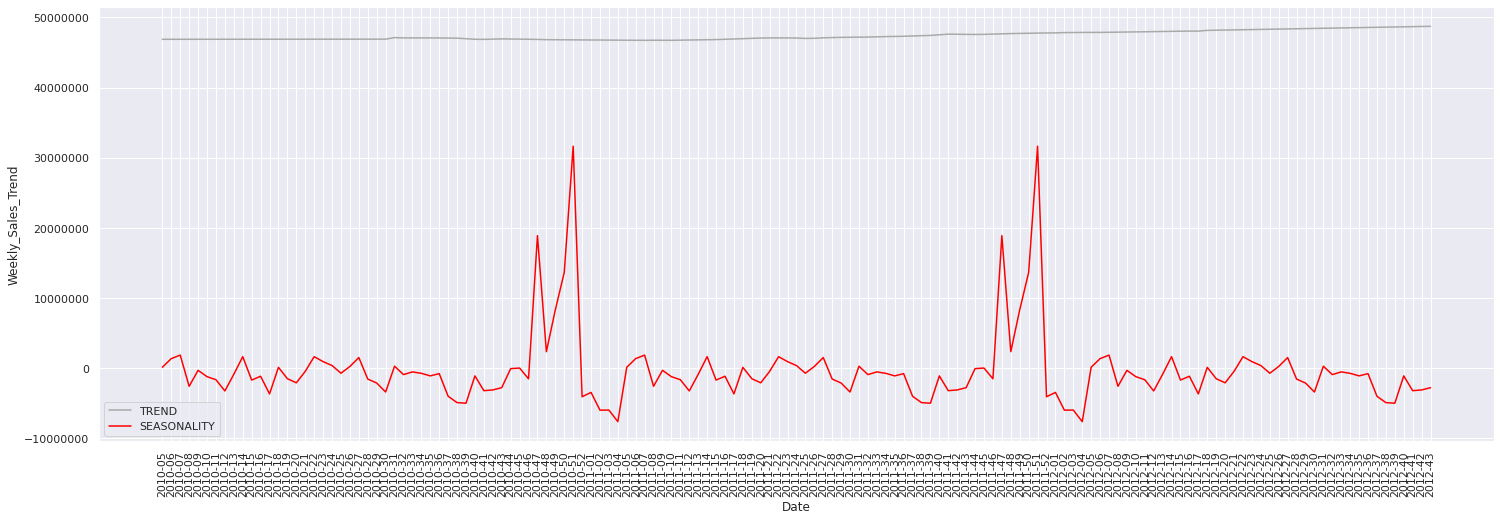

In [16]:
# Opening an empty DF
trend_seasonality = walmart_weekly_sales.copy()

# Decomposing the series into Trend and Seasonality separately
seas_decomp = seasonal_decompose(walmart_weekly_sales.Weekly_Sales, period=52, model='additive', extrapolate_trend='freq')
trend_seasonality['Weekly_Sales_Trend'] = seas_decomp.trend
trend_seasonality['Weekly_Sales_Seasonal'] = seas_decomp.seasonal

# Plot
    # Trend
sns.lineplot(x=trend_seasonality.index, y=trend_seasonality.Weekly_Sales_Trend, color='darkgray', label='TREND')
    # Seasonality
sns.lineplot(x=trend_seasonality.index, y=trend_seasonality.Weekly_Sales_Seasonal, color='red', label='SEASONALITY')  
    # Plot formatting
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
plt.close()

In [17]:
diff_data = walmart_weekly_sales.copy()

In [18]:
train.to_csv('mycsvfile_train.csv',index=False)

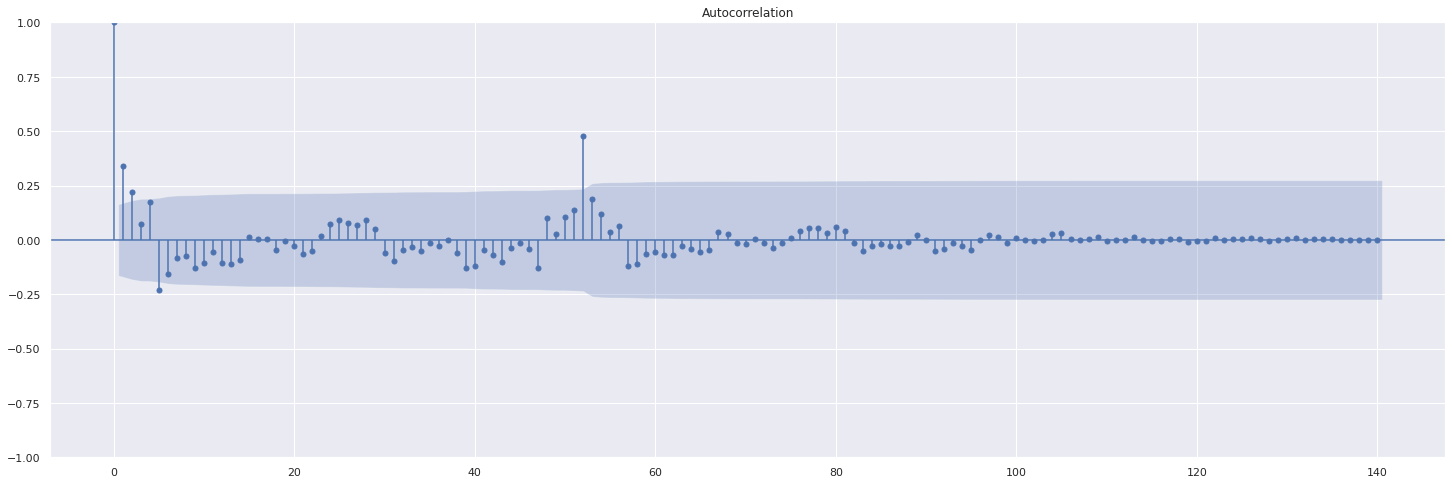

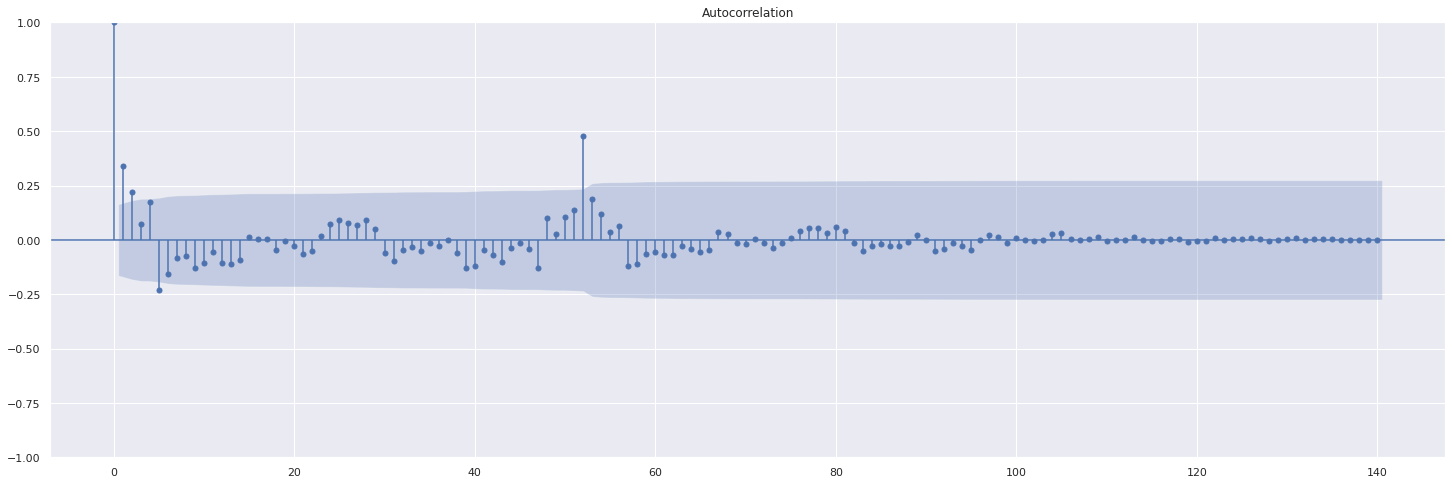

In [19]:
plot_acf(diff_data, lags =140)

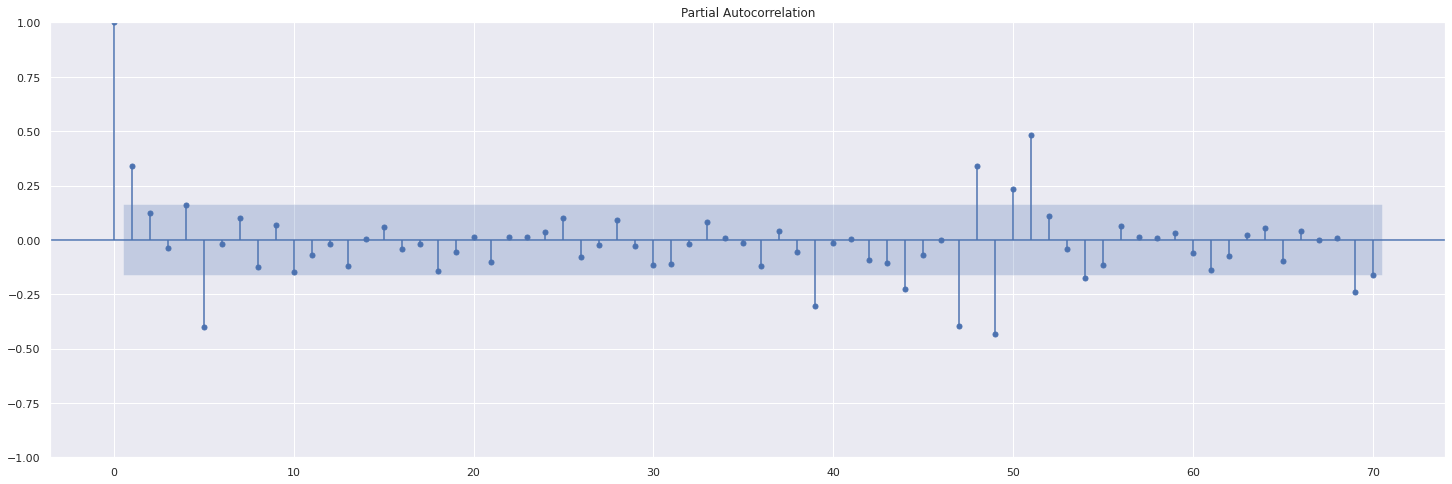

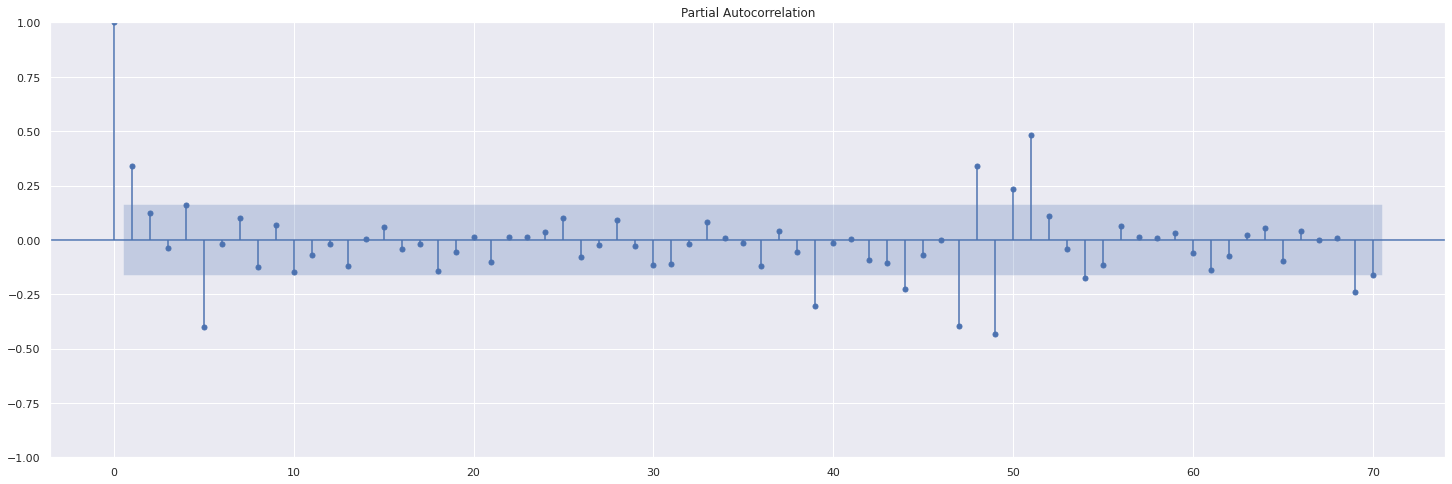

In [20]:
plot_pacf(diff_data, lags =70)

In [21]:
diff_data_1 = diff_data['Weekly_Sales'].diff().dropna()

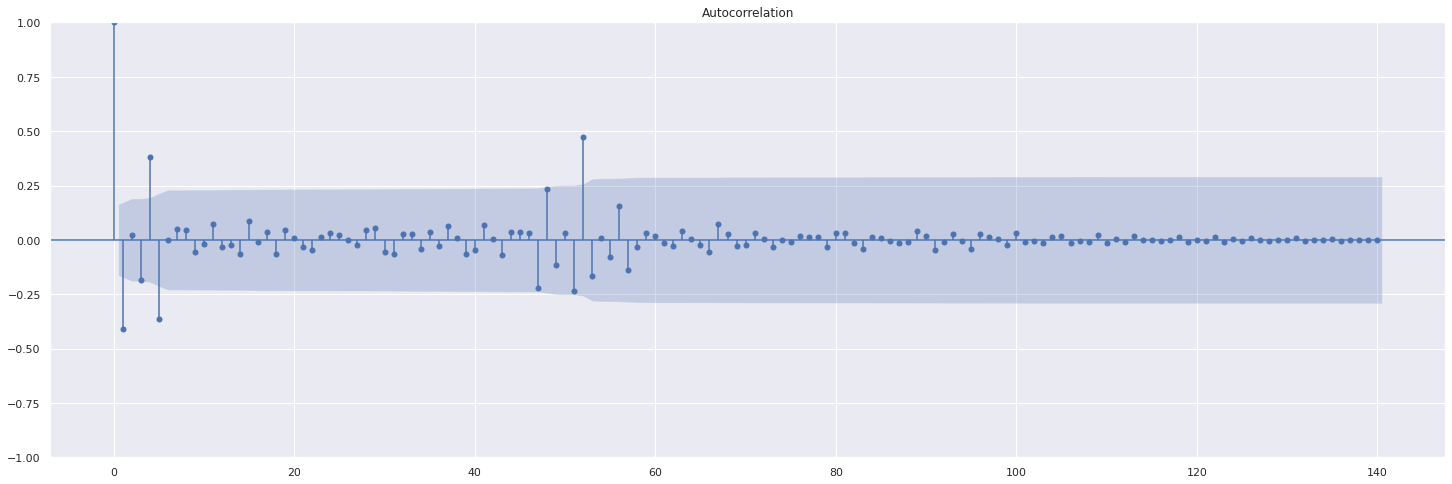

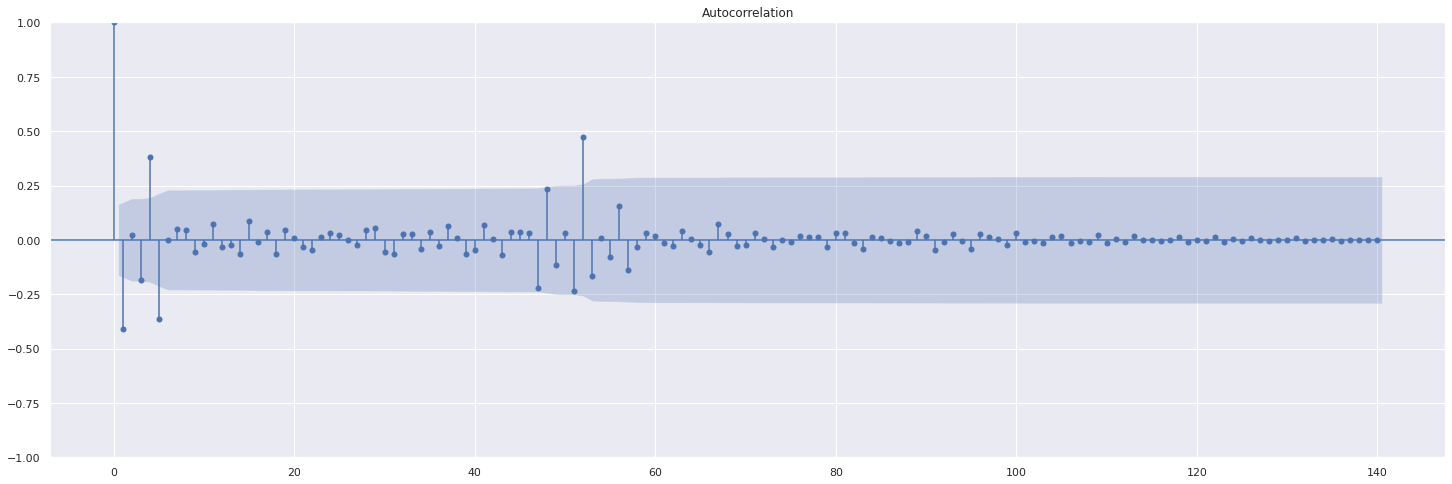

In [22]:
plot_acf(diff_data_1, lags= 140)

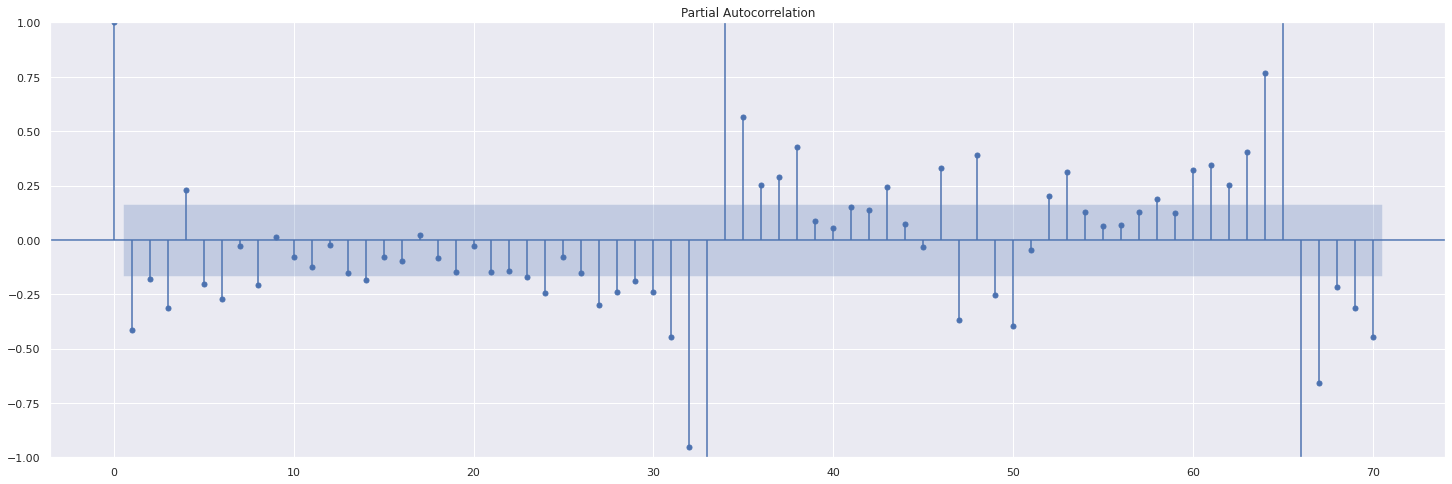

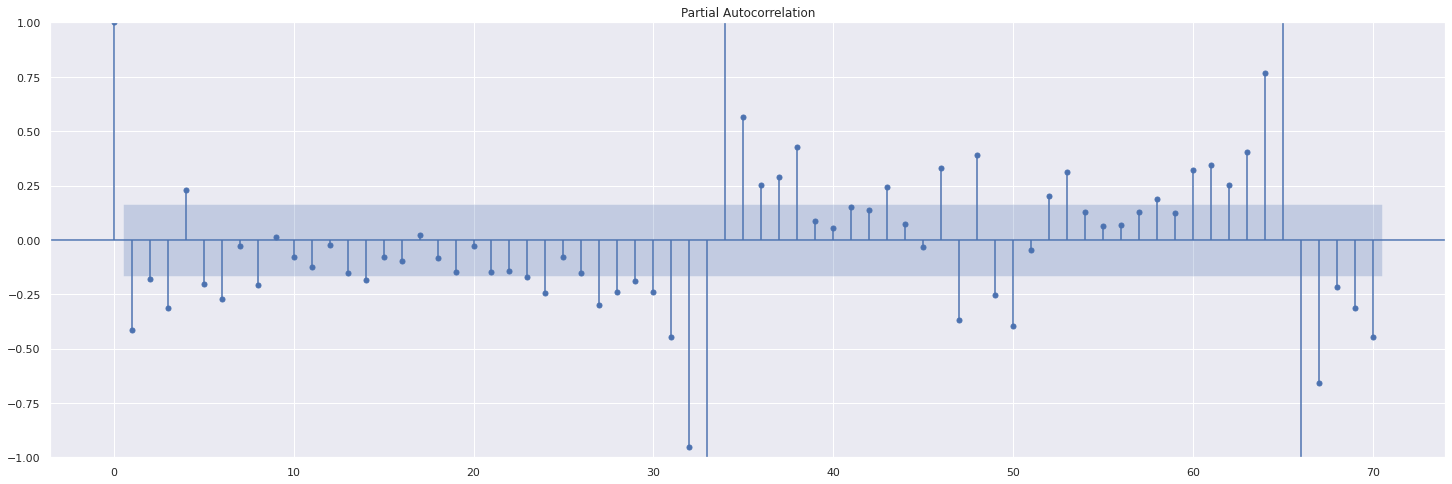

In [23]:
plot_pacf(diff_data_1, lags = 70)

In [24]:
walmart_train_data = walmart_weekly_sales[:int(0.7*(len(walmart_weekly_sales )))]
walmart_test_data = walmart_weekly_sales[int(0.7*(len(walmart_weekly_sales ))):]

train_data = walmart_train_data.Weekly_Sales.values
test_data = walmart_test_data.Weekly_Sales.values

In [25]:
# # Opening hyperparamter recording list
# order_aic_bic = []
# model_number = 1

# # Executing exhaustive search
# for p in range(3):
#     for d in range(2):
#         for q in range(3):
#             for P in range(3):
#                 for D in range(2):
#                     for Q in range(3):
#                         total_models = 3*2*3*3*2*3
#                         try:
#                             model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,52))
#                             results = model.fit(disp=False)
#                             order_aic_bic.append((p, d, q, P, D, Q, 52, results.aic, results.bic))
#                             print(f'{model_number} / {total_models}')
#                             model_number = model_number + 1
#                         except:
#                             print(f'{model_number} / {total_models}')
#                             model_number = model_number + 1
#                             continue

# # Creating a DF with the results
# order_df = pd.DataFrame(order_aic_bic, columns=['AR(p)', 'Diff(d)', 'MA(q)', 'SAR(P)', 'SDiff(D)', 'SMA(Q)', 'Seas(S)', 'AIC', 'BIC'])
# sorted_order_df = order_df.sort_values('AIC')
#print(sorted_order_df.head())

In [26]:
#Model with 1st order differencing
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, start_q=1, start_P=1, start_Q=0,
                  max_p=50, max_q=50, max_P=50, max_Q=50, seasonal=True,maxiter=200, d= 1, max_d = 2,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=2,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)


 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3413.270, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3393.366, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3394.814, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3395.964, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=3395.122, Time=0.17 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=3385.680, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3399.259, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3394.443, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3395.495, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=3389.320, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=3390.059, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=3398.656, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=3397.134, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=3393.018, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=3389.552, Time=0.25 sec
 ARIMA(3,1

ARIMA(maxiter=200, order=(0, 1, 5), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [27]:
# Creating the model
#sarima = SARIMAX(train_data, order=(0,1,1), seasonal_order=(1,1,0,52))

sarima = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,1,1,52))
# Fitting th model
sarima_fit = sarima.fit()

# Summary Statistics of the model
sarima_summary = sarima_fit.summary()
print(sarima_summary)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58111D+00    |proj g|=  3.42732D+00


 This problem is unconstrained.



At iterate    5    f=  7.46089D+00    |proj g|=  7.24936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   4.968D-06   7.460D+00
  F =   7.4599303533136512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -745.993
Date:                            Sun, 04 Dec 2022   AIC                           1497.9

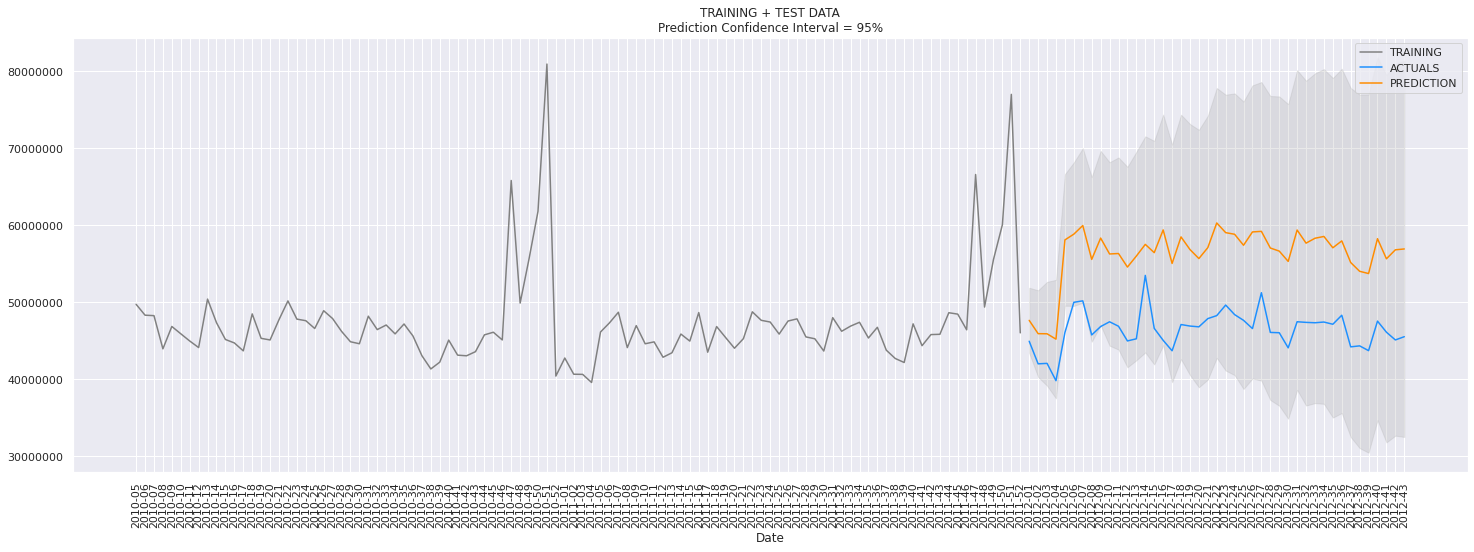

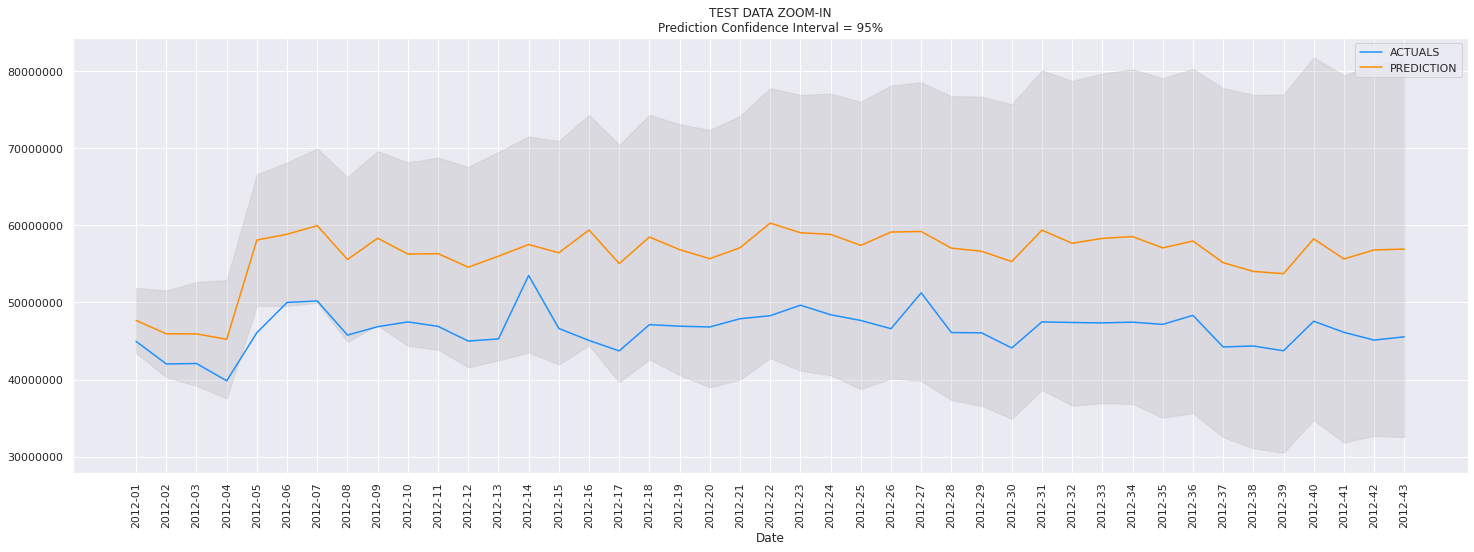

In [28]:
# Model predictions on test set
    # Prediction
predictions = sarima_fit.get_forecast(len(test_data))
    # Mean and prediction interval data
pred_values = predictions.predicted_mean
pred_intervals = predictions.conf_int(alpha=0.05) # 95% Confidence
pred_int_low = pd.Series(pred_intervals[:,0], index=walmart_test_data.index)
pred_int_high = pd.Series(pred_intervals[:,1], index=walmart_test_data.index)


# Plot 1: Full data
    # Training data
sns.lineplot(x=walmart_train_data.index, y=train_data, color='grey', label='TRAINING')
    # Actuals data
sns.lineplot(x=walmart_test_data.index, y=test_data, color='dodgerblue', label='ACTUALS')
    # Prediction data
sns.lineplot(x=walmart_test_data.index, y=pred_values, color='darkorange', label='PREDICTION')
plt.fill_between(pred_int_low.index, pred_int_low, pred_int_high, color='darkgrey', alpha=0.25)
    # Plot formatting
plt.title('TRAINING + TEST DATA\nPrediction Confidence Interval = 95%')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
plt.close()

# Plot 2: Prediction Zoom-In
    # Actuals data
sns.lineplot(x=walmart_test_data.index, y=test_data, color='dodgerblue', label='ACTUALS')
    # Prediction Data
sns.lineplot(x=walmart_test_data.index, y=pred_values, color='darkorange', label='PREDICTION')
plt.fill_between(pred_int_low.index, pred_int_low, pred_int_high, color='darkgrey', alpha=0.25)
    # Plot formatting
plt.title('TEST DATA ZOOM-IN\nPrediction Confidence Interval = 95%')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
plt.close()


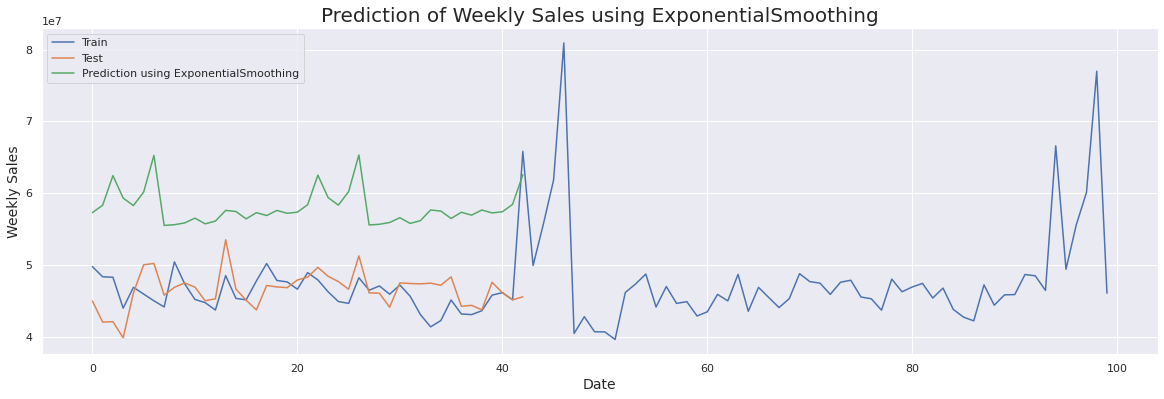

In [29]:
#Exponential Smoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=20, seasonal='additive',trend='additive',damped=True).fit() #Taking additive trend and seasonality.
predictions = model_holt_winters.forecast(len(test_data))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

SUMMARY STATISTICS
Percentage Metrics
MAPE: 20.91%
MPE: 20.91%

Sales Metrics
MAE: 9718951
MSE: 100198061786946
RMSE: 10009898



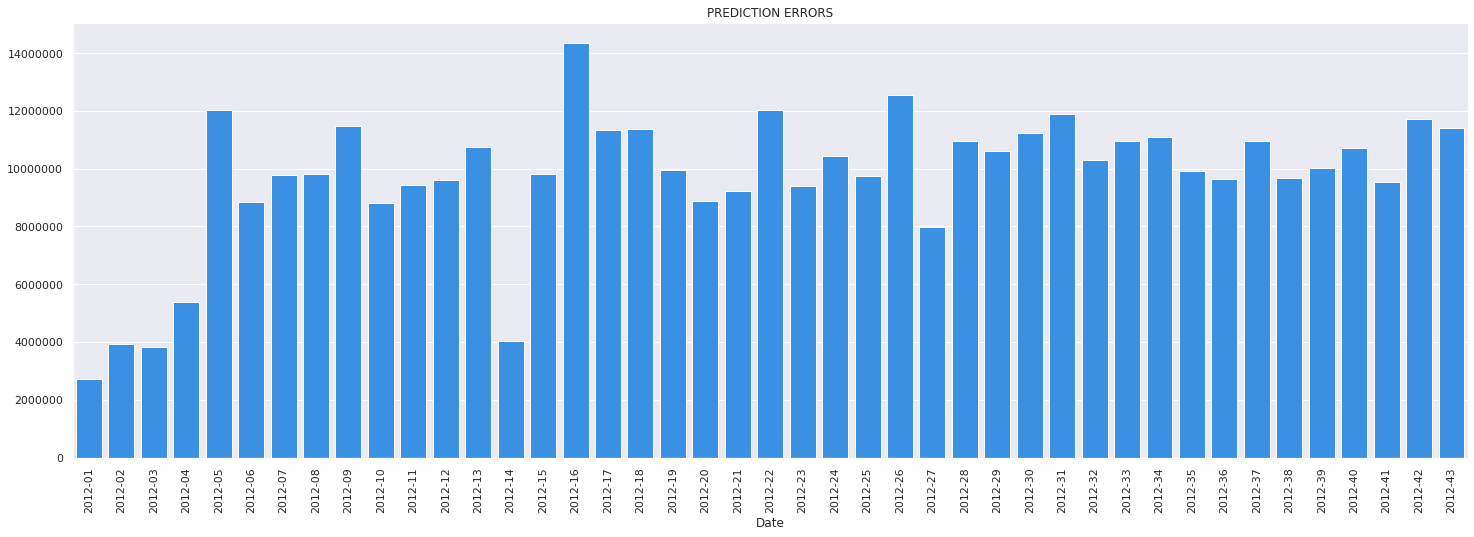

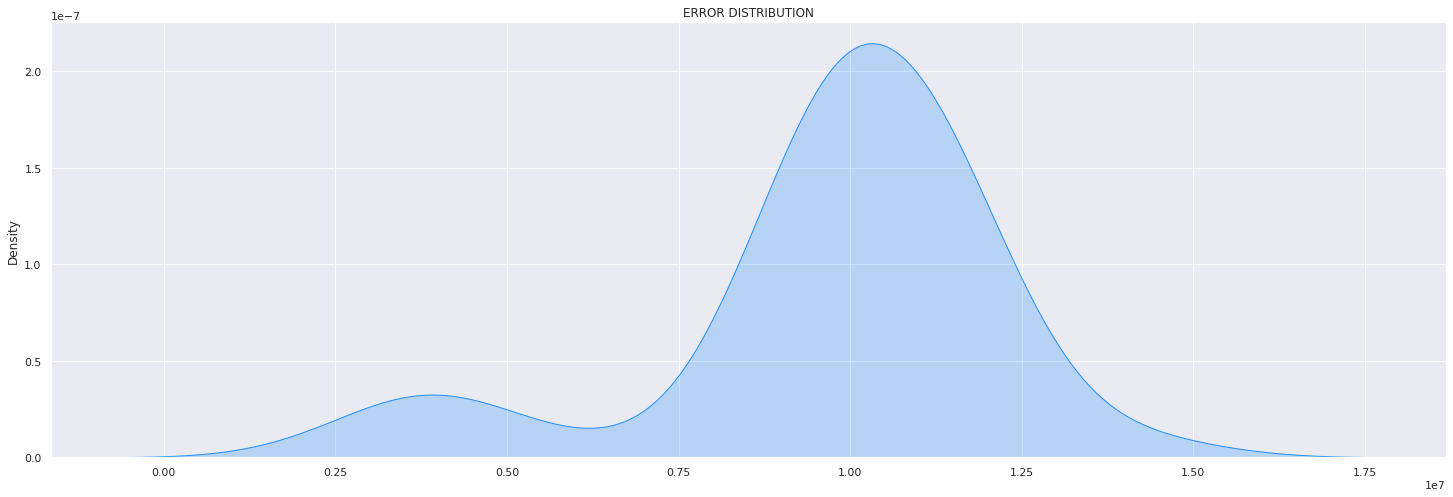

In [30]:
# Model performance analysis
    # Error values
error = pred_values - test_data
error_perc = (pred_values- test_data) / test_data
    # Performance metrics
mae = mean_absolute_error(test_data, pred_values)
mse = mean_squared_error(test_data, pred_values)
rmse = np.sqrt(mse)
mpe = np.mean(error_perc) * 100
mape = (np.mean(abs(error_perc))*100)
print('SUMMARY STATISTICS')
print('Percentage Metrics')
print(f'MAPE: {mape.round(2)}%')
print(f'MPE: {mpe.round(2)}%\n')
print('Sales Metrics')
print(f'MAE: {int(mae)}')
print(f'MSE: {int(mse)}')
print(f'RMSE: {int(rmse)}\n')

# Plot 1: Error Values
sns.barplot(x=walmart_test_data.index, y=error, color='dodgerblue')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.title('PREDICTION ERRORS')
plt.show()
plt.close()

# Plot 2: Error Distribution

sns.kdeplot(x=error, color='dodgerblue', fill=True)
plt.title('ERROR DISTRIBUTION')
plt.show()
plt.close()
